# CUDA performace against number of threads per block

In [1]:
CODE_ROOT = pwd() * "/"

include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean_CUDA.jl")
include(CODE_ROOT * "visualization.jl")

vertexHeatMapMesh (generic function with 1 method)

In [3]:
using Dates

using DelimitedFiles

using BenchmarkTools

import CUDA

In [ ]:
CUDA.CuDevice(0)

In [4]:
function calculate_normal_velocity_tendency_cuda_threadcount!(mpasOcean::MPAS_Ocean_CUDA; threads=1024, maxregs=64)
    CUDA.@cuda blocks=cld(mpasOcean.nEdges, threads) threads=threads maxregs=maxregs calculate_normal_velocity_tendency_cuda_kernel!(
                                                                        mpasOcean.nEdges,
                                                                        mpasOcean.normalVelocityTendency,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.cellsOnEdge,
                                                                        mpasOcean.nEdgesOnEdge,
                                                                        mpasOcean.edgesOnEdge,
                                                                        mpasOcean.weightsOnEdge,
                                                                        mpasOcean.fEdge,
                                                                        mpasOcean.dcEdge,
                                                                        mpasOcean.gravity)
end


calculate_normal_velocity_tendency_cuda_threadcount! (generic function with 1 method)

In [5]:
function update_normal_velocity_by_tendency_cuda_threadcount!(mpasOcean::MPAS_Ocean_CUDA; threads=1024, maxregs=64)
    CUDA.@cuda blocks=cld(mpasOcean.nEdges, threads) threads=threads maxregs=maxregs update_normal_velocity_by_tendency_cuda_kernel!(
                                                                        mpasOcean.nEdges,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.dt,
                                                                        mpasOcean.normalVelocityTendency)
end


update_normal_velocity_by_tendency_cuda_threadcount! (generic function with 1 method)

In [6]:
function calculate_ssh_tendency_cuda_threadcount!(mpasOcean::MPAS_Ocean_CUDA; threads=1024, maxregs=64)
    CUDA.@cuda blocks=cld(mpasOcean.nCells, threads) threads=threads maxregs=maxregs calculate_ssh_tendency_cuda_kernel!(
                                                                        mpasOcean.nCells,
                                                                        mpasOcean.sshTendency,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.bottomDepth,
                                                                        mpasOcean.nEdgesOnCell,
                                                                        mpasOcean.edgesOnCell,
                                                                        mpasOcean.cellsOnCell,
                                                                        mpasOcean.areaCell,
                                                                        mpasOcean.edgeSignOnCell,
                                                                        mpasOcean.dvEdge)
end


calculate_ssh_tendency_cuda_threadcount! (generic function with 1 method)

In [7]:
function update_ssh_by_tendency_cuda_threadcount!(mpasOcean::MPAS_Ocean_CUDA; threads=1024, maxregs=64)
    CUDA.@cuda blocks=cld(mpasOcean.nCells, threads) threads=threads maxregs=maxregs update_ssh_by_tendency_cuda_kernel!(
                                                                        mpasOcean.nCells,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.dt,
                                                                        mpasOcean.sshTendency)
end


update_ssh_by_tendency_cuda_threadcount! (generic function with 1 method)

In [8]:
function forward_backward_step_cuda_threadcount!(mpasOcean::MPAS_Ocean_CUDA;
                                                 threadsCN=1024, threadsUN=1024, threadsCS=1024, threadsUS=1024,
                                                 maxregsCN=64, maxregsUN=64, maxregsCS=64, maxregsUS=64)
    calculate_normal_velocity_tendency_cuda_threadcount!(mpasOcean; threads=threadsCN, maxregs=maxregsCN)

    update_normal_velocity_by_tendency_cuda_threadcount!(mpasOcean; threads=threadsUN, maxregs=maxregsUN)

    calculate_ssh_tendency_cuda_threadcount!(mpasOcean; threads=threadsCS, maxregs=maxregsCS)

    update_ssh_by_tendency_cuda_threadcount!(mpasOcean; threads=threadsUS, maxregs=maxregsUS)
end

forward_backward_step_cuda_threadcount! (generic function with 1 method)

# Test mesh

In [6]:
mpasOcean = MPAS_Ocean(CODE_ROOT * "InertiaGravityWaveMesh",
                    "base_mesh.nc",
                    "mesh.nc", periodicity="Periodic")
typeof(mpasOcean)

MPAS_Ocean

# Define Initial Condition

In [7]:
include("mode_init/exactsolutions.jl")

DetermineInertiaGravityWaveExactSurfaceElevation (generic function with 1 method)

In [14]:
nx, ny, etaHat = 1, 2, 1e-1
etaHat, f0, kX, kY, omega = inertiaGravityWaveParams(mpasOcean, nx, ny, etaHat)
inertiaGravityExactSolution!(mpasOcean, etaHat, f0, kX, kY, omega, 0.0) # could also do gaussianInit!

In [15]:
mpasOcean.layerThickness

1×10000 Matrix{Float64}:
 1000.1  1000.1  1000.1  1000.1  1000.1  …  1000.1  1000.1  1000.1  1000.1

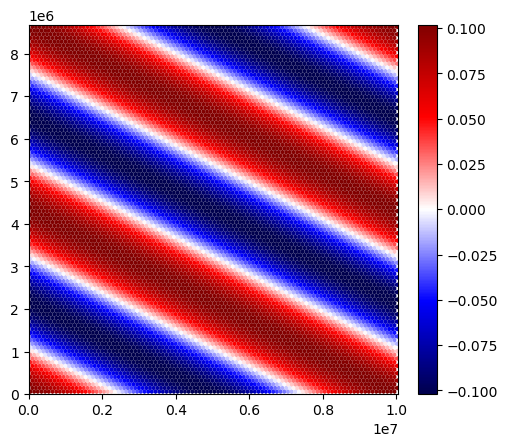

In [19]:
fig, ax, cbar, col = heatMapMesh(mpasOcean, mpasOcean.layerThickness[1,:]-mpasOcean.bottomDepth)
display(fig)

# Compare benchmarks with different threads per block
Initially, only threads per block of ssh calculation and update changes

In [22]:
function threadcount_test(; mpasOcean=mpasOcean, minblocksize=64, maxblocksize=1024, cases=8, periodicity="Periodic")
    threadcounts = []
    ttimes = []

    for blocksize::Integer in Int.(round.(range(minblocksize, maxblocksize, length=cases)))
        
        println("Now benchmarking with $blocksize threads per block.")
        
        bench = @benchmark forward_backward_step_cuda_threadcount!($mpasOcean; threadsCS=$blocksize, threadsUS=$blocksize) seconds=5
        
        append!(threadcounts, [blocksize])
    
        append!(ttimes, [bench.times])

    end

    means = []
    for times in ttimes
        append!(means, mean(times))
    end

    stdevs = []
    for i in 1:length(ttimes)
        append!(stdevs, sqrt(mean( (ttimes[i] .- means[i]).^2 )) )
    end
    
    return threadcounts, ttimes, means, stdevs
end

threadcount_test (generic function with 1 method)

In [ ]:
mpasOcean = MPAS_Ocean_CUDA(mpasOcean)
mpasOceanCUDA.nCells

In [ ]:
threadcountsS, ttimesS, meansS, stdevsS = threadcount_test(mpasOcean=mpasOcean,
                                                            minblocksize=16, maxblocksize=1024, cases=64)
threadcountsS

In [20]:
savedata = true
if savedata
    fpath = CODE_ROOT * "output/cuda_occupancy/"
    mkpath(fpath)
    fname = "$fpath$(Dates.now()).txt"
    open(fname, "w") do io
        writedlm(io, [threadcountsS, ttimesS, meansS, stdevsS])
    end
    println("saved to $fname")
end

saved to /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/cuda_occupancy/2022-12-14T16:56:46.807.txt


In [24]:
function latestfile(dir, filterfunc)
    return filter(filterfunc, readdir(dir, join=true))[end]
end

latestfile (generic function with 1 method)

In [81]:
usesaved = true
if usesaved
    fpath = CODE_ROOT * "output/cuda_occupancy/"
    fname = latestfile(fpath, x->endswith(x,".txt"))
    data = replace(readdlm(fname), ""=>0)
    threadcountsS = data[1,1:64]
    ttimesS =       parse.(Float64, replace.(reshape(data[2,:], (64,10000)), r"[\,\[\]]"=>""))
    meansS =        data[3,1:64]
    stdevsS =       data[4,1:64]
end

64-element Vector{Any}:
 46305.49480280916
 47220.53953652013
 46584.479714356785
 46624.558747530435
 46625.9043699038
 46723.906568486775
 46805.381011198035
 46893.350799604166
 46828.91133946886
 46928.2265407235
 46950.77651881264
 47076.32636750085
 47150.26617090447
     ⋮
 49729.928750373416
 49659.96737716798
 49799.08924222765
 50246.71297134815
  6421.474607242308
 50163.28844226649
 49888.39290962601
 50362.51401195198
 49915.05073932262
 50767.74670592609
 50241.241628910946
  6644.718263312983

## Plot benchmarks against resolution

In [101]:
means = []
stdevs = []

for i in 1:size(ttimesS)[1]
    append!(means, mean(ttimesS[i]))
    append!(stdevs, sqrt(mean( (ttimesS[i] .- means[i]).^2 )) )
end

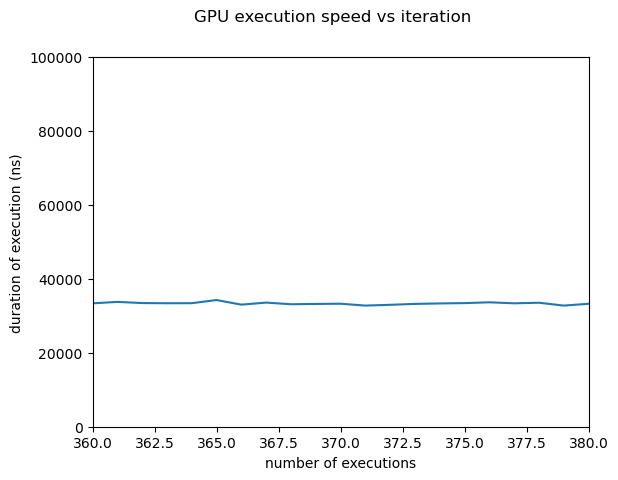

PyObject Text(0.5, 24.0, 'number of executions')

In [98]:
plt.plot(ttimesS[63,:])
plt.ylim(0, 100000)
plt.xlim(360, 380)
plt.suptitle("GPU execution speed vs iteration")
plt.ylabel("duration of execution (ns)")
plt.xlabel("number of executions")

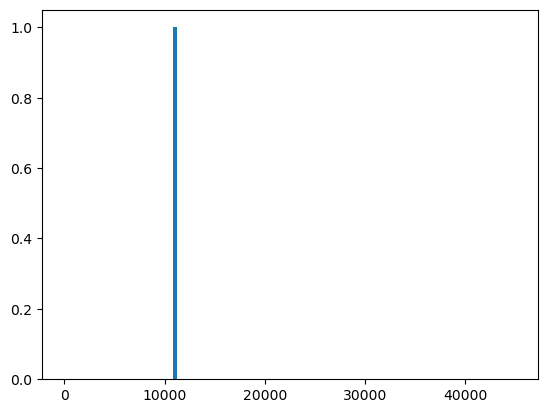

(11058.0, 39063.2559)

In [85]:
hist(ttimesS[63], bins=100, range=[0,45000])
maximum(ttimesS[63]), meansS[63]

In [86]:
times = mapreduce(permutedims, vcat, ttimesS)

LoadError: MethodError: no method matching permutedims(::Float64)
[0mClosest candidates are:
[0m  permutedims([91m::StridedArray[39m, [91m::Any[39m) at multidimensional.jl:1555
[0m  permutedims([91m::LinearAlgebra.SymTridiagonal[39m) at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/LinearAlgebra/src/tridiag.jl:165
[0m  permutedims([91m::LinearAlgebra.SymTridiagonal[39m, [91m::Any[39m) at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/LinearAlgebra/src/tridiag.jl:166
[0m  ...

In [102]:
times = means

64-element Vector{Any}:
 53050.0
 16351.0
 14043.0
 12084.0
 11941.0
 11510.0
 11909.0
 11186.0
 11441.0
 10947.0
 11569.0
 11290.0
 11459.0
     ⋮
 11005.0
 10757.0
 11084.0
 11147.0
 11162.0
 10850.0
 10879.0
 10709.0
 10852.0
 10941.0
 11058.0
 10708.0

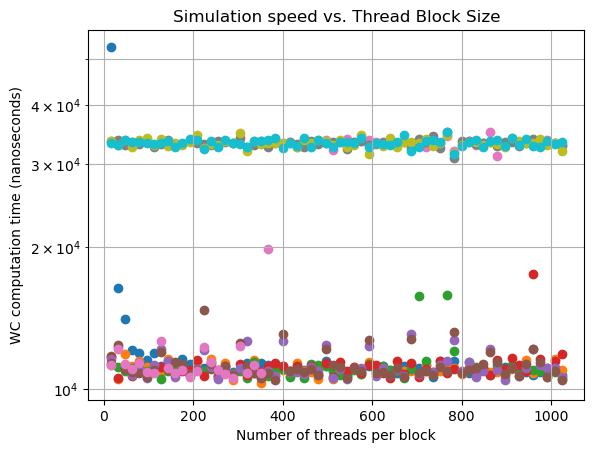

PyObject Text(0.5, 1.0, 'Simulation speed vs. Thread Block Size')

In [109]:
fig, ax = subplots(1,1)

# ax.set_xscale("log")
ax.set_yscale("log")

for i in 1:10
#     println(size(threadcountsS, size()))
    scatter(threadcountsS[:,:], ttimesS[:,i]) #[:,i]
end
# plot(threadcountsS, meansS, marker="s") # yerr=stdevsC
# errorbar(threadcountsS, meansS, yerr=stdevsS, linestyle="None")

ylabel("WC computation time (nanoseconds)")
xlabel("Number of threads per block")

# legend()

grid(which="both")

title("Simulation speed vs. Thread Block Size")

In [94]:
lowmeans = zeros(size(meansS))
for i in 1:size(times)[1]
    lowmeans[i] = mean(times[i,:300])
end

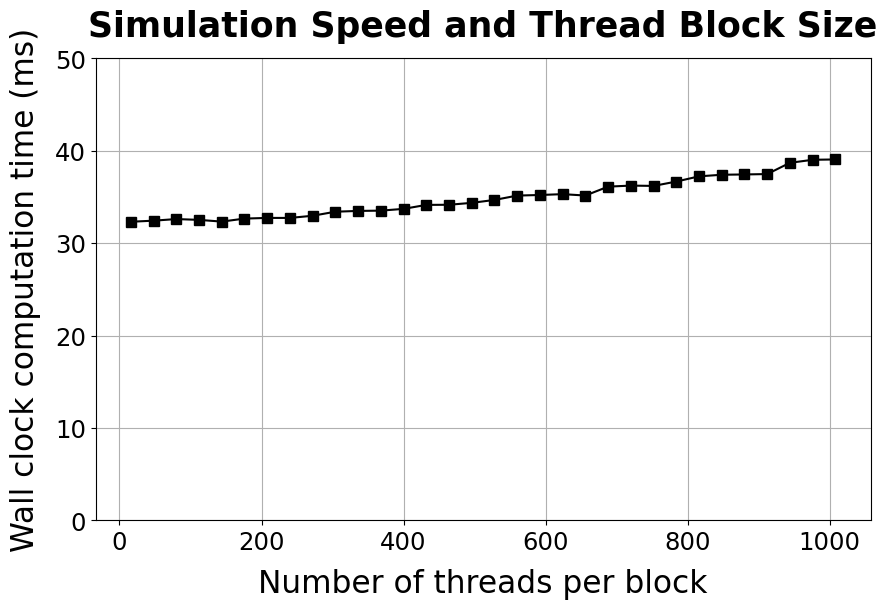

PyObject Text(0.5, 1.03, 'Simulation Speed and Thread Block Size')

In [110]:
fig, ax = subplots(1,1, figsize=(10,6))

# ax.set_xscale("log")
# ax.set_yscale("log")

plot(threadcountsS[1:2:end], meansS[1:2:end]/1000, marker="s", markersize=7.5, color="black") # yerr=stdevsC
# errorbar(threadcountsS, meansS, yerr=stdevsS, linestyle="None")

plt.ylim(0, 50)

ylabel("Wall clock computation time (ms)", fontsize=22.5, labelpad=10)
xlabel("Number of threads per block", fontsize=22.5, labelpad=10)
ax.tick_params(axis="both", which="major", labelsize=17.5)

# legend()

grid(which="both")

title("Simulation Speed and Thread Block Size", fontweight="bold", fontsize=25, y=1.03)

In [18]:
saveplot = true
if saveplot
    fig.savefig(CODE_ROOT * "output/cuda_occupancy/speed_occupancy_plot.pdf", bbox_inches="tight")
    println("saved")
end

saved


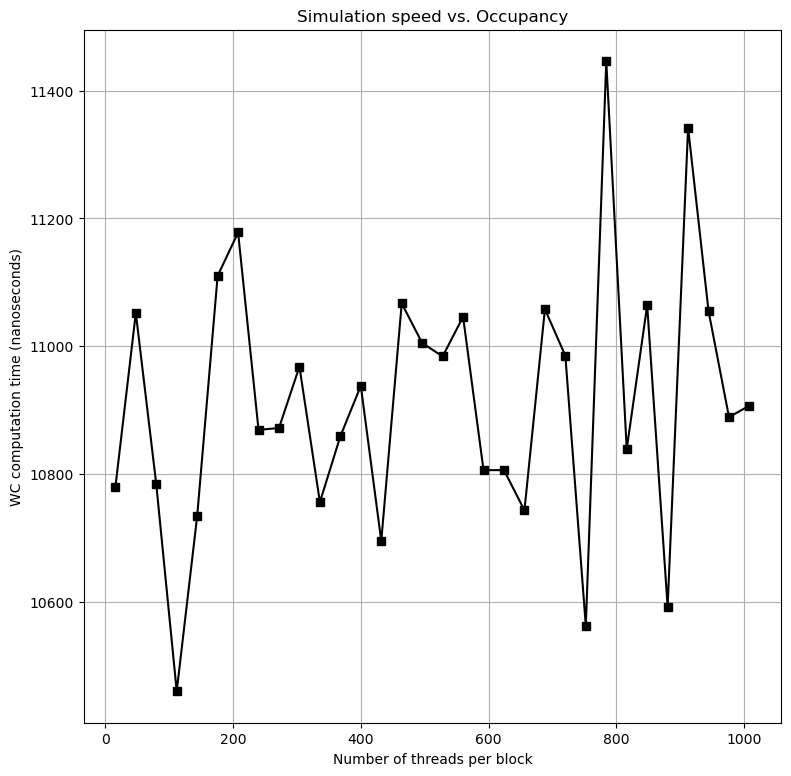

PyObject Text(0.5, 1.0, 'Simulation speed vs. Occupancy')

In [95]:
fig, ax = subplots(1,1, figsize=(9,9))

# ax.set_xscale("log")
# ax.set_yscale("log")

plot(threadcountsS[1:2:end], lowmeans[1:2:end], marker="s", color="black") # yerr=stdevsC
# errorbar(threadcountsS, meansS, yerr=stdevsS, linestyle="None")

ylabel("WC computation time (nanoseconds)")
xlabel("Number of threads per block")

# legend()

grid(which="both")

title("Simulation speed vs. Occupancy")

In [18]:
kernelnorm = CUDA.@cuda launch=false calculate_normal_velocity_tendency_cuda_kernel!(
                                                                        mpasOcean.nEdges,
                                                                        mpasOcean.normalVelocityTendency,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.cellsOnEdge,
                                                                        mpasOcean.nEdgesOnEdge,
                                                                        mpasOcean.edgesOnEdge,
                                                                        mpasOcean.weightsOnEdge,
                                                                        mpasOcean.fEdge,
                                                                        mpasOcean.dcEdge,
                                                                        mpasOcean.gravity)

CUDA.HostKernel{typeof(calculate_normal_velocity_tendency_cuda_kernel!), Tuple{Int64, CUDA.CuDeviceVector{Float64, 1}, CUDA.CuDeviceVector{Float64, 1}, CUDA.CuDeviceVector{Float64, 1}, CUDA.CuDeviceMatrix{Int32, 1}, CUDA.CuDeviceVector{Int32, 1}, CUDA.CuDeviceMatrix{Int32, 1}, CUDA.CuDeviceMatrix{Float64, 1}, CUDA.CuDeviceVector{Float64, 1}, CUDA.CuDeviceVector{Float64, 1}, Float64}}(calculate_normal_velocity_tendency_cuda_kernel!, CuContext(0x00000000057cbda0, instance 558b5aa46fd4a7d8), CUDA.CuModule(Ptr{Nothing} @0x00000000083161a0, CuContext(0x00000000057cbda0, instance 558b5aa46fd4a7d8)), CUDA.CuFunction(Ptr{Nothing} @0x0000000008417af0, CUDA.CuModule(Ptr{Nothing} @0x00000000083161a0, CuContext(0x00000000057cbda0, instance 558b5aa46fd4a7d8))))

In [19]:
CUDA.launch_configuration(kernelnorm.fun)

(blocks = 20, threads = 1024)

In [20]:
CUDA.maxthreads(kernelnorm)

1024

In [21]:
threadcounts = collect(1:1:1024)

occupancies = collect([CUDA.occupancy(kernelnorm.fun, t) for t in threadcounts])

1024-element Vector{Float64}:
 0.015625
 0.03125
 0.046875
 0.0625
 0.078125
 0.09375
 0.109375
 0.125
 0.140625
 0.15625
 0.171875
 0.1875
 0.203125
 ⋮
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.5

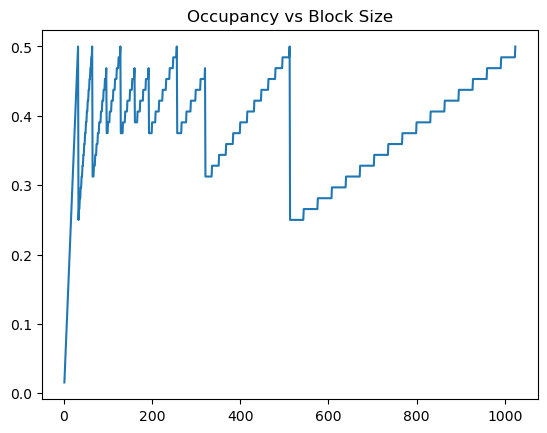

PyObject Text(0.5, 1.0, 'Occupancy vs Block Size')

In [24]:
plot(threadcounts, occupancies)

title("Occupancy vs Block Size")

In [21]:
CUDA.occupancy(kernelnorm.fun, 1)

0.015625

In [11]:
cld(mpasOcean.nEdges, 1024)

8

In [12]:
mpasOcean.nEdges/20

375.0